In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip -qq install --pre torch torchvision torchaudio --extra-index-url "https://download.pytorch.org/whl/nightly/cuda"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.3 MB/s eta 0:00:00


In [3]:
!pip -qq install -r "/content/drive/MyDrive/Image and Video Understanding/MRCNN/requirements.txt"

In [4]:
!pip -qq install 'git+https://github.com/facebookresearch/detectron2.git'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 80.3 MB/s eta 0:00:00


In [ ]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

import os
import torch
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, hooks
from detectron2.evaluation import COCOEvaluator
import multiprocessing
multiprocessing.set_start_method("spawn", force=True)

# === CONFIG PARAMETERS ===
data_dir = '/content/drive/MyDrive/Image and Video Understanding/MRCNN/dataset'
trained_model = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
class_number = 20
batch_size = 16
iter_number = 3000
learning_rate = 0.00025
data_loader_worker_number = 0
images_number_per_batch = 8
prediction_confidence = 0.5
image_size = 960

# ✅ New custom output directory
output_dir = "/content/drive/MyDrive/Image and Video Understanding/MRCNN/results"

# === CLEAN OLD REGISTRATION IF EXISTS ===
for name in ["taco_train", "taco_val", "taco_test"]:
    if name in DatasetCatalog.list():
        DatasetCatalog.remove(name)
        MetadataCatalog.remove(name)

# === REGISTER DATASETS ===
register_coco_instances("taco_train", {}, f"{data_dir}/annotations_train.json", f"{data_dir}/images")
register_coco_instances("taco_test", {}, f"{data_dir}/annotations_test.json", f"{data_dir}/images")
register_coco_instances("taco_val", {}, f"{data_dir}/annotations_val.json", f"{data_dir}/images")

# === CONFIG SETUP ===
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(trained_model))

cfg.DATASETS.TRAIN = ("taco_train",)
cfg.DATASETS.TEST = ("taco_test",)
cfg.DATALOADER.NUM_WORKERS = data_loader_worker_number

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(trained_model)
cfg.SOLVER.IMS_PER_BATCH = images_number_per_batch
cfg.SOLVER.BASE_LR = learning_rate
cfg.SOLVER.MAX_ITER = iter_number
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = batch_size
cfg.MODEL.ROI_HEADS.NUM_CLASSES = class_number

cfg.INPUT.MIN_SIZE_TRAIN = (image_size,)
cfg.INPUT.MIN_SIZE_TEST = image_size
cfg.INPUT.MAX_SIZE_TRAIN = image_size
cfg.INPUT.MAX_SIZE_TEST = image_size

# ✅ Set output directory
cfg.OUTPUT_DIR = output_dir
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# === SAVE CONFIG TO FILE ===
with open(os.path.join(cfg.OUTPUT_DIR, "config.yaml"), "w") as f:
    f.write(cfg.dump())

# === DEVICE SETUP ===
cfg.MODEL.DEVICE = "cuda"  # or "cuda" if using GPU

# === TRAIN ===
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# === PREDICTION ===
from detectron2.engine import DefaultPredictor

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = prediction_confidence
cfg.DATASETS.TEST = ("taco_test", )
predictor = DefaultPredictor(cfg)

# === VISUALIZATION ===
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer
import cv2
import random
import matplotlib.pyplot as plt

# Load the dataset
dataset_dicts = DatasetCatalog.get("taco_test")
metadata = MetadataCatalog.get("taco_test")

for d in random.sample(dataset_dicts, 5):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)

    print("Predictions:", outputs["instances"].to("cpu"))

    # Visualization
    v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=1.0)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Show result
    plt.figure(figsize=(10, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# === EVALUATE ON TEST SET ===
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

print("\n=== Running COCO Evaluation on taco_test ===")
evaluator = COCOEvaluator("taco_test", cfg, False, output_dir=os.path.join(cfg.OUTPUT_DIR, "eval"))
val_loader = build_detection_test_loader(cfg, "taco_test")
metrics = inference_on_dataset(predictor.model, val_loader, evaluator)

# Optional: Save summary to CSV/JSON
import json
import csv

# Save JSON
with open(os.path.join(cfg.OUTPUT_DIR, "eval", "metrics_summary.json"), "w") as f:
    json.dump(metrics, f, indent=4)



=== Running COCO Evaluation on taco_test ===
WARNING [07/12 15:21:49 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [07/12 15:21:49 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/12 15:21:49 d2.data.datasets.coco]: Loaded 136 images in COCO format from /content/drive/MyDrive/Image and Video Understanding/MRCNN/dataset/annotations_test.json
[07/12 15:21:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(960, 960), max_size=960, sample_style='choice')]
[07/12 15:21:49 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/12 15:21:49 d2.data.common]: Serializing 136 elements to byte tensors and concatenating them all ...
[07/12 15:21:49 d2.data.common]: Serialized dataset takes 0.18 MiB
[07/12 15:2

In [ ]:
import torch
import numpy as np
from detectron2.engine import DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode, Instances, Boxes, pairwise_iou
import os
import cv2
from tqdm import tqdm

# (Your existing imports and configuration from your provided code)

# === CONFIG PARAMETERS (from your provided code) ===
data_dir = '/content/drive/MyDrive/Image and Video Understanding/MRCNN/dataset'
trained_model = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
class_number = 20 # Assuming 20 actual classes + 1 for background if needed in CM
batch_size = 16
iter_number = 3000
learning_rate = 0.00025
data_loader_worker_number = 0
images_number_per_batch = 8
prediction_confidence = 0.5
image_size = 960
output_dir = "/content/drive/MyDrive/Image and Video Understanding/MRCNN/results"

# === CLEAN OLD REGISTRATION IF EXISTS ===
for name in ["taco_train", "taco_val", "taco_test"]:
    if name in DatasetCatalog.list():
        DatasetCatalog.remove(name)
        MetadataCatalog.remove(name)

# === REGISTER DATASETS ===
register_coco_instances("taco_train", {}, f"{data_dir}/annotations_train.json", f"{data_dir}/images")
register_coco_instances("taco_test", {}, f"{data_dir}/annotations_test.json", f"{data_dir}/images")
register_coco_instances("taco_val", {}, f"{data_dir}/annotations_val.json", f"{data_dir}/images")

# === CONFIG SETUP ===
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(trained_model))

cfg.DATASETS.TRAIN = ("taco_train",)
cfg.DATASETS.TEST = ("taco_test",)
cfg.DATALOADER.NUM_WORKERS = data_loader_worker_number

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(trained_model)
cfg.SOLVER.IMS_PER_BATCH = images_number_per_batch
cfg.SOLVER.BASE_LR = learning_rate
cfg.SOLVER.MAX_ITER = iter_number
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = batch_size
cfg.MODEL.ROI_HEADS.NUM_CLASSES = class_number # This should be the number of actual classes (e.g., 20)
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = prediction_confidence # For RetinaNet, if you're using it
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = prediction_confidence # For R-CNN based models

cfg.INPUT.MIN_SIZE_TRAIN = (image_size,)
cfg.INPUT.MIN_SIZE_TEST = image_size
cfg.INPUT.MAX_SIZE_TRAIN = image_size
cfg.INPUT.MAX_SIZE_TEST = image_size

cfg.OUTPUT_DIR = output_dir
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


def get_confusion_matrix(model_path: str, cfg, dataset_name: str = "taco_test", iou_threshold: float = 0.5):
    """
    Calculates and returns the confusion matrix for a Detectron2 model on a specified dataset.

    Args:
        model_path (str): Path to the trained model's .pth file (e.g., "model_final.pth").
        cfg (CfgNode): The Detectron2 configuration object.
        dataset_name (str): The name of the dataset to evaluate (e.g., "taco_test").
        iou_threshold (float): IoU threshold to consider a prediction a match for a ground truth.

    Returns:
        tuple: A tuple containing:
            - numpy.ndarray: The confusion matrix.
            - list: List of class names (including "background" or "no object").
    """
    # Load the trained model weights
    cfg.MODEL.WEIGHTS = model_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = prediction_confidence  # Set confidence for inference
    predictor = DefaultPredictor(cfg)

    # Get dataset dictionaries
    dataset_dicts = DatasetCatalog.get(dataset_name)
    metadata = MetadataCatalog.get(dataset_name)
    class_names = metadata.thing_classes

    # Add a "background" or "no object" class to the labels for the confusion matrix
    # This accounts for cases where a ground truth object is missed (FN) or
    # a prediction is made where there is no ground truth (FP).
    # The actual class indices usually start from 0 for the first class.
    # So, if your classes are 0-19, "background" will be class_number.
    cm_class_names = class_names + ["background"]
    num_classes_cm = len(cm_class_names) # includes background

    true_labels = []
    predicted_labels = []

    # Iterate through the dataset
    for i, data_dict in enumerate(tqdm(dataset_dicts, desc=f"Generating predictions for {dataset_name}")):
        img_path = data_dict["file_name"]
        image = cv2.imread(img_path)

        if image is None:
            print(f"Warning: Could not read image {img_path}. Skipping.")
            continue

        outputs = predictor(image)
        instances = outputs["instances"].to("cpu")

        # Get ground truth boxes and classes
        # Convert ground truth annotations to Instances object for easier handling
        gt_boxes_coco = [obj["bbox"] for obj in data_dict["annotations"]]
        gt_classes = [obj["category_id"] for obj in data_dict["annotations"]]
        gt_boxes = Boxes(torch.tensor(gt_boxes_coco, dtype=torch.float32))

        # Convert COCO bbox format [x,y,w,h] to [x1,y1,x2,y2]
        gt_boxes_xyxy = BoxMode.convert(gt_boxes.tensor.numpy(), BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
        gt_instances = Instances(image.shape[:2])
        gt_instances.pred_boxes = Boxes(torch.tensor(gt_boxes_xyxy, dtype=torch.float32))
        gt_instances.pred_classes = torch.tensor(gt_classes, dtype=torch.int64)


        # Get predicted boxes and classes
        pred_boxes = instances.pred_boxes
        pred_classes = instances.pred_classes
        pred_scores = instances.scores

        # Filter predictions by confidence
        valid_predictions_mask = pred_scores >= prediction_confidence
        pred_boxes = pred_boxes[valid_predictions_mask]
        pred_classes = pred_classes[valid_predictions_mask]

        # Initialize matched status for both ground truths and predictions
        gt_matched = [False] * len(gt_instances)
        pred_matched = [False] * len(pred_classes)

        if len(gt_instances) > 0 and len(pred_boxes) > 0:
            # Calculate IoU between ground truth and predicted boxes
            ious = pairwise_iou(gt_instances.pred_boxes, pred_boxes) # gt_instances x pred_boxes

            # Match predictions to ground truths using Hungarian algorithm or simple greedy approach
            # A greedy approach: find the best match for each ground truth
            for gt_idx, gt_box in enumerate(gt_instances.pred_boxes):
                best_iou = -1
                best_pred_idx = -1
                for pred_idx, pred_box in enumerate(pred_boxes):
                    if not pred_matched[pred_idx] and ious[gt_idx, pred_idx] > best_iou:
                        best_iou = ious[gt_idx, pred_idx]
                        best_pred_idx = pred_idx

                if best_iou >= iou_threshold:
                    # Match found
                    true_labels.append(gt_instances.pred_classes[gt_idx].item())
                    predicted_labels.append(pred_classes[best_pred_idx].item())
                    gt_matched[gt_idx] = True
                    pred_matched[best_pred_idx] = True

        # Handle False Negatives (unmatched ground truths)
        for gt_idx, matched in enumerate(gt_matched):
            if not matched:
                true_labels.append(gt_instances.pred_classes[gt_idx].item())
                predicted_labels.append(num_classes_cm - 1)  # Assign to 'background' class

        # Handle False Positives (unmatched predictions)
        for pred_idx, matched in enumerate(pred_matched):
            if not matched:
                true_labels.append(num_classes_cm - 1)  # True label is 'background'
                predicted_labels.append(pred_classes[pred_idx].item())

    # Calculate the confusion matrix
    # labels argument ensures all classes (0 to num_classes_cm - 1) are included
    cm = confusion_matrix(true_labels, predicted_labels, labels=list(range(num_classes_cm)))

    return cm, cm_class_names




Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

Generating predictions for taco_test: 100%|██████████| 136/136 [00:26<00:00,  5.15it/s]


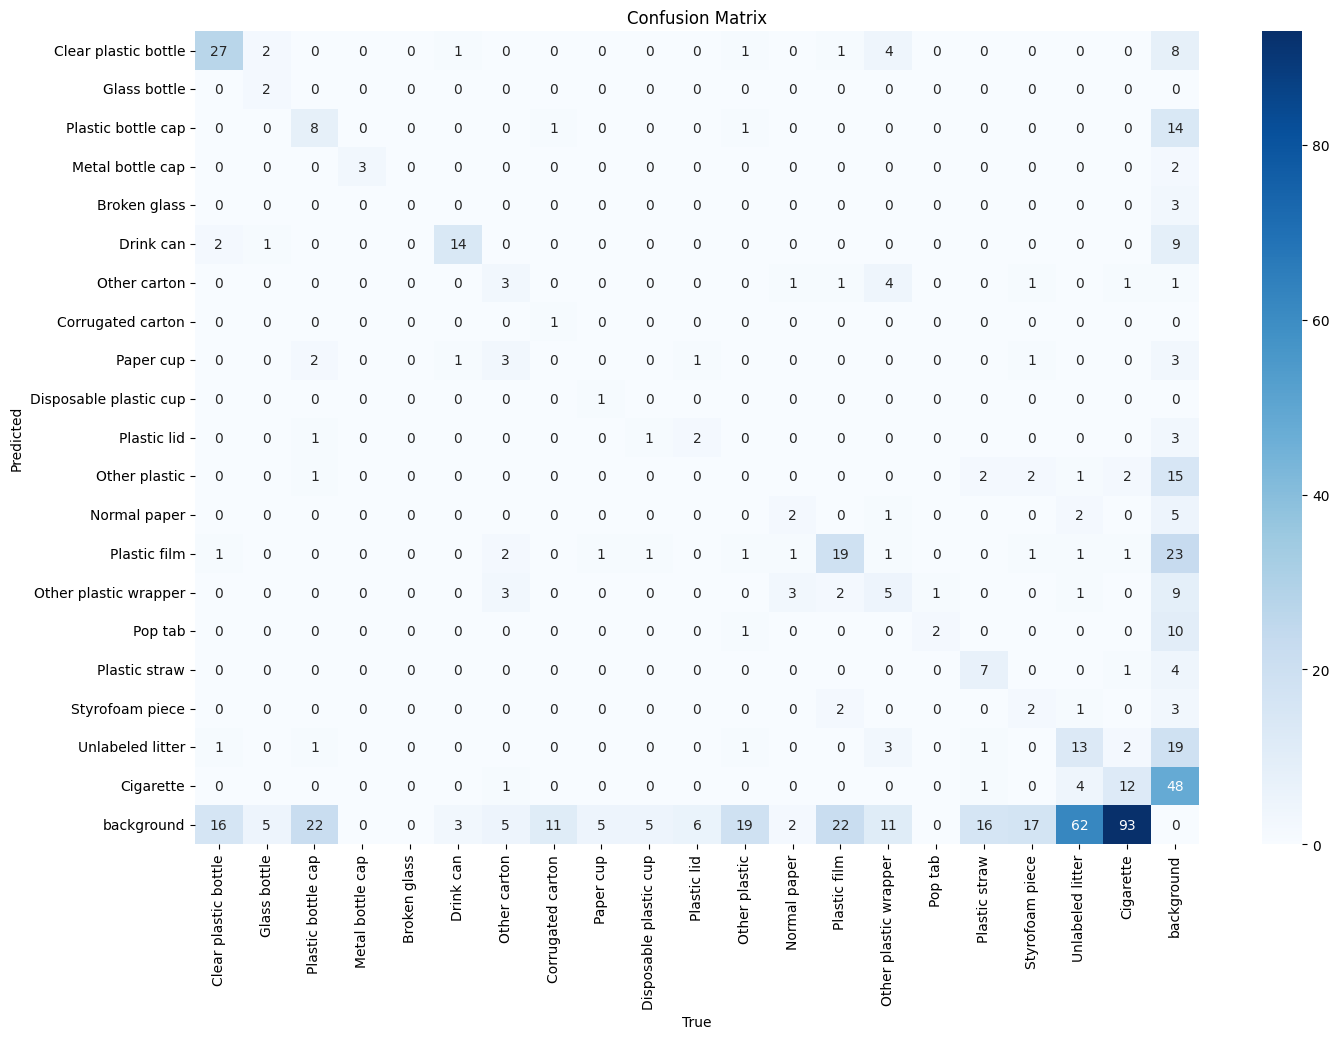

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_confusion_matrix_from_image(image_labels, confusion_matrix_data, title='Confusion Matrix'):
    """
    Plots a confusion matrix similar to the provided image.

    Args:
        image_labels (list): A list of strings representing the labels for the classes.
                             These should correspond to the order in the confusion matrix.
        confusion_matrix_data (list or np.array): A 2D list or NumPy array
                                                  representing the confusion matrix values.
        title (str, optional): The title of the plot. Defaults to 'Confusion Matrix'.
    """

    # Convert the confusion matrix data to a NumPy array if it's not already
    cm = np.array(confusion_matrix_data, dtype=int)

    # Calculate the size for the plot based on the number of labels
    num_labels = len(image_labels)
    figsize_width = max(10, num_labels * 0.7)  # Adjust these factors as needed
    figsize_height = max(8, num_labels * 0.5)

    plt.figure(figsize=(figsize_width, figsize_height))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=image_labels, yticklabels=image_labels)

    plt.title(title)
    plt.ylabel('Predicted')
    plt.xlabel('True')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


image_labels = [
    "Clear plastic bottle", "Glass bottle", "Plastic bottle cap",
    "Metal bottle cap", "Broken glass", "Drink can", "Other carton",
    "Corrugated carton", "Paper cup", "Disposable plastic cup",
    "Plastic lid", "Other plastic", "Normal paper", "Plastic film",
    "Other plastic wrapper", "Pop tab", "Plastic straw",
    "Styrofoam piece", "Unlabeled litter", "Cigarette", "background"
]

cm, cm_class_names = get_confusion_matrix(os.path.join(cfg.OUTPUT_DIR, "/content/drive/MyDrive/Image and Video Understanding/MRCNN/results/model_final.pth"), cfg)

plot_confusion_matrix_from_image(image_labels, cm)

In [15]:
import os
import json
import cv2
import torch
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import Boxes, Instances

def visualize_prediction_vs_ground_truth(cfg, json_annotation_path, metadata, predictor, image_name):
    # === Load annotations ===
    with open(json_annotation_path, "r") as f:
        coco_json = json.load(f)

    # === Find the image entry for the specified image name ===
    image_info = next((img for img in coco_json["images"] if img["file_name"] == image_name), None)
    if image_info is None:
        raise ValueError(f"Image '{image_name}' not found in annotations.")

    image_path = os.path.join(
        "/content/drive/MyDrive/Image and Video Understanding/MRCNN/dataset/images/",
        image_name
    )

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image: {image_path}")

    image_id = image_info["id"]

    # === Prepare category ID to class index mapping ===
    cat_id_to_idx = {cat["id"]: idx for idx, cat in enumerate(coco_json["categories"])}
    class_names = [cat["name"] for cat in coco_json["categories"]]

    # === Get ground truth annotations for this image ===
    annotations = [ann for ann in coco_json["annotations"] if ann["image_id"] == image_id]

    # === Run predictor ===
    outputs = predictor(image)
    instances = outputs["instances"].to("cpu")

    # === Draw predictions ===
    v = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.0)
    pred_vis = v.draw_instance_predictions(instances)

    # === Prepare ground truth Instances ===
    gt_boxes = []
    gt_classes = []
    for ann in annotations:
        bbox = ann["bbox"]  # COCO format: [x, y, width, height]
        x, y, w, h = bbox
        gt_boxes.append([x, y, x + w, y + h])
        gt_classes.append(cat_id_to_idx[ann["category_id"]])

    if len(gt_boxes) == 0:
        print("⚠️ No ground truth instances for this image.")
        gt_vis_image = image[:, :, ::-1]
    else:
        gt_instances = Instances(image.shape[:2])
        gt_instances.pred_boxes = Boxes(torch.tensor(gt_boxes, dtype=torch.float32))
        gt_instances.pred_classes = torch.tensor(gt_classes, dtype=torch.int64)

        # === Draw ground truth ===
        v_gt = Visualizer(image[:, :, ::-1], metadata={"thing_classes": class_names}, scale=1.0)
        gt_vis = v_gt.draw_instance_predictions(gt_instances)
        gt_vis_image = gt_vis.get_image()[:, :, ::-1]

    # === Show both side by side ===
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(pred_vis.get_image()[:, :, ::-1])
    plt.title("Predictions")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(gt_vis_image)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.show()


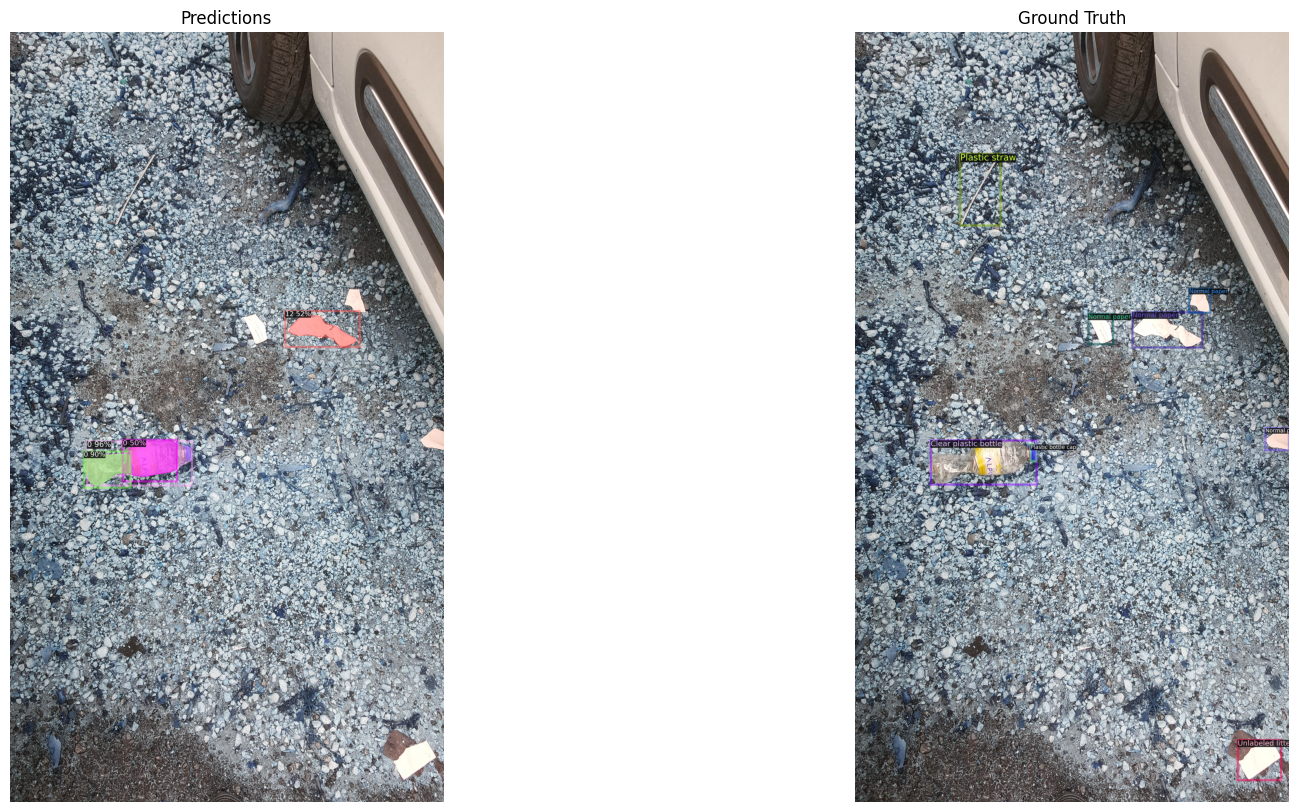

In [16]:
import os
import json
import cv2
import random
import torch
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import Boxes, Instances
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.config import get_cfg


# def visualize_prediction_vs_ground_truth(cfg, json_annotation_path, metadata, predictor):
#     with open(json_annotation_path, "r") as f:
#         coco_json = json.load(f)

#     # === Pick random image ===
#     image_info = random.choice(coco_json["images"])
#     file_name = image_info["file_name"]
#     image_id = image_info["id"]

#     # === Construct full image path ===
#     image_path = os.path.join(cfg.INPUT.DATASET_ROOT, "images", file_name) \
#         if hasattr(cfg.INPUT, "DATASET_ROOT") else os.path.join("/content/drive/MyDrive/Image and Video Understanding/MRCNN/dataset/images", file_name)

#     image = cv2.imread(image_path)
#     print(image_path)
#     if image is None:
#         raise ValueError(f"Could not load image: {image_path}")

#     # === Load GT Annotations ===
#     annotations = [ann for ann in coco_json["annotations"] if ann["image_id"] == image_id]

#     # === Predictor ===
#     outputs = predictor(image)
#     instances = outputs["instances"].to("cpu")

#     # === Visualize prediction ===
#     v = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.0)
#     pred_vis = v.draw_instance_predictions(instances)

#     # === Prepare GT instances ===
#     gt_boxes = []
#     gt_classes = []
#     for ann in annotations:
#         x, y, w, h = ann["bbox"]
#         gt_boxes.append([x, y, x + w, y + h])
#         gt_classes.append(ann["category_id"])

#     if not gt_boxes:
#         print("⚠️ No ground truth instances for this image.")
#         return

#     gt_instances = Instances(image.shape[:2])
#     gt_instances.pred_boxes = Boxes(torch.tensor(gt_boxes, dtype=torch.float32))
#     gt_instances.pred_classes = torch.tensor(gt_classes, dtype=torch.int64)

#     # === Visualize GT ===
#     v_gt = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.0)
#     gt_vis = v_gt.draw_instance_predictions(gt_instances)

#     # === Show side by side ===
#     plt.figure(figsize=(20, 10))
#     plt.subplot(1, 2, 1)
#     plt.imshow(pred_vis.get_image()[:, :, ::-1])
#     plt.title("Predictions")
#     plt.axis("off")

#     plt.subplot(1, 2, 2)
#     plt.imshow(gt_vis.get_image()[:, :, ::-1])
#     plt.title("Ground Truth")
#     plt.axis("off")
#     plt.show()


# === CONFIG ===
data_dir = '/content/drive/MyDrive/Image and Video Understanding/MRCNN/dataset'
output_dir = "/content/drive/MyDrive/Image and Video Understanding/MRCNN/results"
ann_path = os.path.join(data_dir, "annotations_test.json")

# === Register datasets ===
for name in ["taco_train", "taco_test", "taco_val"]:
    if name in DatasetCatalog.list():
        DatasetCatalog.remove(name)
        MetadataCatalog.remove(name)

register_coco_instances("taco_train", {}, f"{data_dir}/annotations_train.json", f"{data_dir}/images")
register_coco_instances("taco_test", {}, f"{data_dir}/annotations_test.json", f"{data_dir}/images")
register_coco_instances("taco_val", {}, f"{data_dir}/annotations_val.json", f"{data_dir}/images")

# === Setup cfg ===
cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/Image and Video Understanding/MRCNN/results/train_1000_iter/config.yaml")
cfg.DATASETS.TEST = ("taco_test",)
cfg.DATASETS.TRAIN = ("taco_train",)
cfg.DATALOADER.NUM_WORKERS = 0
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 16
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 20
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.INPUT.MIN_SIZE_TEST = 960
cfg.INPUT.MAX_SIZE_TEST = 960
cfg.OUTPUT_DIR = output_dir

# === Load weights (if already trained) ===
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
predictor = DefaultPredictor(cfg)

# === Metadata ===
metadata = MetadataCatalog.get("taco_val")

# === Visualize ===
visualize_prediction_vs_ground_truth(cfg, ann_path,metadata, predictor, '293.jpg')
